## Day 17: RANSAC

### Goals
* Understand the Random Sample Consensus (RANSAC) algorithm
* Know how to use RANSAC to robustly fit transformations in the presence of outliers
* Apply RANSAC to fit translation and homography models

In [1]:
# boilerplate setup
%matplotlib inline

# Library imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Rectangle, Polygon

### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - SIFT/MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [x] Translation
    * [x] Affine
    * [x] Projective
    * [ ] **Robustness to outliers - RANSAC**
* Warp image(s) into common coordinate system and blend

Recall our definition of the optimal transformation for a given set of correspondences is the one that **minimizes** the sum of squared residuals:
$$
\min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')||^2
$$

### The Problem: Robustness to outliers

Least squares fitting works great when all your matches are correct (inliers). But what happens when you have **outliers** - incorrect matches that don't follow the true transformation?

Even a few outliers can completely ruin a least squares fit!

#### Demo: Line Fitting with Outliers

Let's demonstrate this problem with a simple example: fitting a line to 2D points.

We'll generate points that lie on a line (with small noise), then add varying percentages of **outliers** - points that don't follow the line at all. Let's see how least squares handles this!

In [2]:
def generate_line_data(n_inliers=50, outlier_percentage=0, noise_sigma=0.5):
    """Generate 2D points lying on a line, with optional outliers.
    
    Args:
        n_inliers: number of points that follow the line
        outlier_percentage: percentage of outliers to add (0-100)
        noise_sigma: standard deviation of noise for inliers
    
    Returns:
        x: x-coordinates (1D array)
        y: y-coordinates (1D array)
        is_inlier: boolean array indicating which points are inliers
    """
    # Ground truth line: y = 2x + 1
    x_inliers = np.random.uniform(-5, 5, n_inliers)
    y_inliers = 2 * x_inliers + 1 + np.random.normal(0, noise_sigma, n_inliers)
    
    # Generate outliers
    n_outliers = int(n_inliers * outlier_percentage / 100)
    x_outliers = np.random.uniform(-5, 5, n_outliers)
    y_outliers = np.random.uniform(-10, 15, n_outliers)  # Random y values
    
    # Combine
    x = np.concatenate([x_inliers, x_outliers])
    y = np.concatenate([y_inliers, y_outliers])
    is_inlier = np.concatenate([np.ones(n_inliers, dtype=bool), 
                                np.zeros(n_outliers, dtype=bool)])
    
    return x, y, is_inlier

In [3]:
def fit_line_least_squares(x, y):
    """Fit a line y = mx + b using least squares.
    
    Returns:
        m: slope
        b: intercept
    """
    # Set up linear system: [x 1] * [m; b] = y
    A = np.vstack([x, np.ones(len(x))]).T
    # Solve using least squares
    result = np.linalg.lstsq(A, y, rcond=None)
    m, b = result[0]
    return m, b

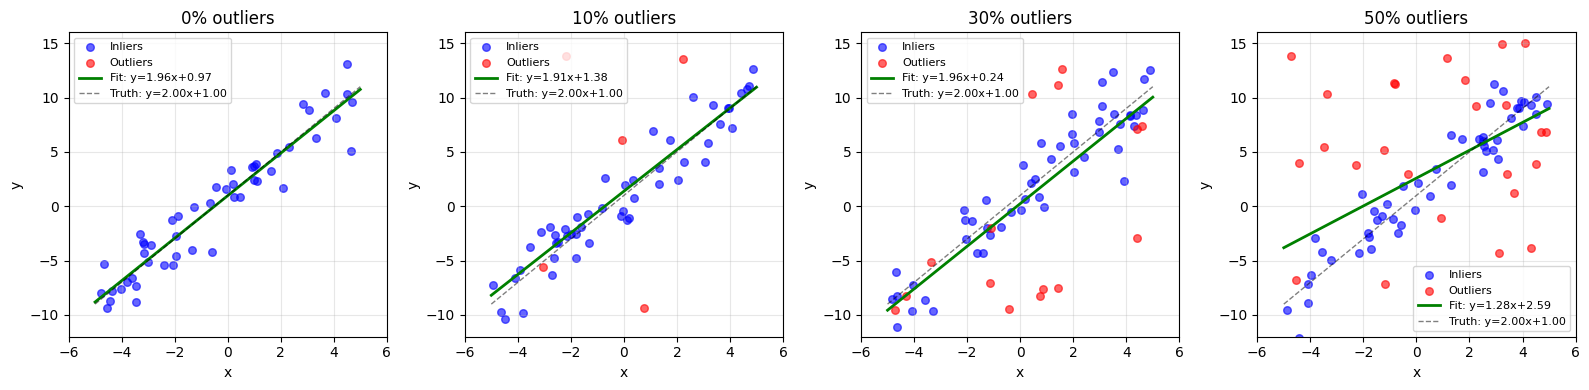

In [4]:
# Visualize how least squares degrades with more outliers
outlier_percentages = [0, 10, 30, 50]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
np.random.seed(42)  # For reproducibility

for i, outlier_pct in enumerate(outlier_percentages):
    ax = axes[i]
    
    # Generate data
    x, y, is_inlier = generate_line_data(n_inliers=50, 
                                         outlier_percentage=outlier_pct,
                                         noise_sigma=2)
    
    # Fit line
    m, b = fit_line_least_squares(x, y)
    
    # Plot
    ax.scatter(x[is_inlier], y[is_inlier], c='blue', s=30, alpha=0.6, label='Inliers')
    ax.scatter(x[~is_inlier], y[~is_inlier], c='red', s=30, alpha=0.6, label='Outliers')
    
    # Plot fitted line
    x_line = np.array([-5, 5])
    y_line = m * x_line + b
    ax.plot(x_line, y_line, 'g-', linewidth=2, label=f'Fit: y={m:.2f}x+{b:.2f}')
    
    # Plot ground truth
    y_gt = 2 * x_line + 1
    ax.plot(x_line, y_gt, 'k--', linewidth=1, alpha=0.5, label='Truth: y=2.00x+1.00')
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-12, 16)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{outlier_pct}% outliers')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Setup: Building Experimental Tools

Let's complexify the demo above. We'll build the same sort of thing, but for a computer vision problem.

We'll need:
- Matches (both inliers and outliers)
- Code that can estimate a transformation
- Code that can apply a transformation
- Visualization tools

Let's get this working in the noise-free case first. Then we're ready to tackle outliers.

In [5]:
# Demo: create synthetic matches for testing
img_w = 600
img_h = 480
T_gt = np.array(   # gt = ground truth 
    [[1, 0, 70],
     [0, 1, -30],
     [0, 0, 1]]
)

# points in left image, row/col pixel coords
n_inlier_matches = 16
pts_L = np.vstack([
    np.random.randint(0.2*img_h, 0.8*img_h, n_inlier_matches),
    np.random.randint(0.2*img_w, 0.8*img_w, n_inlier_matches),
])
pts_L.shape

(2, 16)

In [6]:
def apply_T(pts, T):
    """Apply a 3x3 transformation matrix to 2D points.
    
    Args:
        pts: 2-by-n matrix of 2D image coords (row, col)
        T: 3-by-3 transformation matrix
    
    Returns:
        2-by-n matrix of transformed points
    """
    n = pts.shape[1]

    # add a one to each vector (make homogeneous)
    pts = np.vstack([pts, np.ones(n)])
    pts_T = T @ pts # multiply by T

    # divide by third row and drop it (normalize homogeneous coords)
    pts_T = pts_T[0:2,:] / pts_T[2,:]
    return pts_T

pts_R = apply_T(pts_L, T_gt)
print(pts_R.shape)

(2, 16)


In [7]:
def fit_translation_model(pts_L, pts_R):
    """Fit a translation using least squares.
    
    Returns a 3x3 matrix T that maps coords in img_L to
    their matching coords in img_R using a translation model.
    """
    diff = pts_R - pts_L
    avg_diff = np.sum(diff, axis=1) / pts_L.shape[1]
    T = np.identity(3)
    T[0:2,2] = avg_diff
    return T

In [8]:
# check: does it work on noise-free data?
apply_T(pts_L, T_gt) - pts_R

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
def visualize_matches(pts_L, pts_R, img_w, img_h,
                      match_colors=None,
                      img_outer_pad = 60,  # border around images
                      img_inner_pad = 100, # space between images
                      ax=None
                     ):
    """Visualize correspondences between two images.
    
    Args:
        pts_L: 2-by-n matrix of points in left image (row, col)
        pts_R: 2-by-n matrix of corresponding points in right image (row, col)
        img_w: image width
        img_h: image height
        match_colors: optional list of colors for each match (default: green)
    """
    
    # define global to local coords transforms for both images
    def L2g(pts_L):
        # pts_L coords are (row,col) with (0,0) in upper left
        assert len(pts_L.shape) == 2 and pts_L.shape[0] == 2
        return np.vstack([
            pts_L[1,:] + img_outer_pad,
            img_h + img_outer_pad - pts_L[0,:]
        ])
    def R2g(pts_R):
        # pts_R coords are (row,col) with (0,0) in upper left
        assert len(pts_R.shape) == 2 and pts_R.shape[0] == 2
        return np.vstack([
            pts_R[1,:] + img_outer_pad + img_inner_pad + img_w,
            img_h + img_outer_pad - pts_R[0,:]
        ])

    # Axis setup
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,4))
    viz_w = 2*img_outer_pad + img_inner_pad + 2 * img_w
    viz_h = 2*img_outer_pad + img_h
    ax.axis('off')
    ax.add_patch(Rectangle((0, 0), viz_w, viz_h, color='#f2f2f2')) #background grey
    ax.set_xlim(0, viz_w)
    ax.set_ylim(0, viz_h)
    ax.set_aspect('equal')


    # plot elements, in local image coords
    img_frame = np.array([
        [0, 0,       img_h-1, img_h-1],
        [0, img_w-1, img_w-1, 0      ]
    ])
    text_loc = np.array([[img_h + 10],[img_w/2]])

    # draw image frames and keypoint points
    ax.add_patch(Polygon(L2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    ax.add_patch(Polygon(R2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    
    # Text labels - extract scalar coordinates
    text_L = L2g(text_loc)
    text_R = R2g(text_loc)
    ax.text(text_L[0, 0], text_L[1, 0], "Left Image",  ha='center', va='top')
    ax.text(text_R[0, 0], text_R[1, 0], "Right Image", ha='center', va='top')
    
    ax.plot(*L2g(pts_L), '.k', markersize=8)
    ax.plot(*R2g(pts_R), '.k', markersize=8)
    
    # add lines between matches
    for i in range(pts_L.shape[1]):
        c = 'g' if match_colors is None else match_colors[i]
        pL = L2g(pts_L)[:,i]
        pR = R2g(pts_R)[:,i]
        ax.plot([pL[0], pR[0]], [pL[1], pR[1]], '-', color=c, linewidth=0.5)
    
    plt.show()

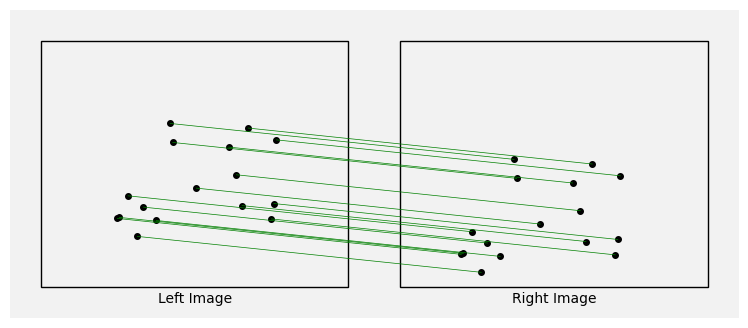

In [10]:
visualize_matches(pts_L, pts_R, img_w, img_h)

In [11]:
def visualize_model(pts_L, pts_R, model, img_w, img_h,
          match_colors=None,
          img_outer_pad = 60,  # border around images
          ax=None
         ):
    """Visualize how well a model fits the correspondences.
    
    Shows the right image with:
    - Black dots: actual right image points
    - Purple dots: predicted right image points (left points transformed by model)
    - Lines connecting predictions to actual points (residuals)
    """
    
    # define global to local coords transforms for both images
    def I2g(pts):
        # pts coords are (row,col) with (0,0) in upper left
        assert len(pts.shape) == 2 and pts.shape[0] == 2
        return np.vstack([
            pts[1,:] + img_outer_pad,
            img_h + img_outer_pad - pts[0,:]
        ])

    # Axis setup
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,4))
    viz_w = 2*img_outer_pad + img_w
    viz_h = 2*img_outer_pad + img_h
    ax.axis('off')
    ax.add_patch(Rectangle((0, 0), viz_w, viz_h, color='#f2f2f2')) #background grey
    ax.set_xlim(0, viz_w)
    ax.set_ylim(0, viz_h)
    ax.set_aspect('equal')


    # plot elements, in local image coords
    img_frame = np.array([
        [0, 0,       img_h-1, img_h-1],
        [0, img_w-1, img_w-1, 0      ]
    ])
    text_loc = np.array([[img_h + 10],[img_w/2]])

    # map left points into right image via model. Put into viz coords (g)
    pts_R_g       = I2g(pts_R)
    pts_R_model_g = I2g(apply_T(pts_L, model))

    # draw image frames and keypoint points
    ax.add_patch(Polygon(I2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    
    # Text label - extract scalar coordinates
    text_pos = I2g(text_loc)
    ax.text(text_pos[0, 0], text_pos[1, 0], "Right Image", ha='center', va='top')
    
    ax.plot(*pts_R_g, '.k', markersize=8)
    ax.plot(*pts_R_model_g, '.', color='purple', markersize=8)

    
    # add lines between matches
    for i in range(pts_R.shape[1]):
        c = 'purple' if match_colors is None else match_colors[i]
        pt_pred = pts_R_model_g[:,i]
        pt_real = pts_R_g[:,i]
        ax.plot([pts_R_model_g[0,i], pts_R_g[0,i]], 
                [pts_R_model_g[1,i], pts_R_g[1,i]], 
                '-', color=c, linewidth=0.5)
    
    plt.show()

[[  1.   0.  70.]
 [  0.   1. -30.]
 [  0.   0.   1.]]


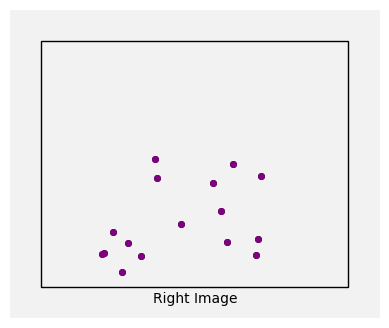

In [12]:
model = fit_translation_model(pts_L, pts_R)
print(model)
visualize_model(pts_L, pts_R, model, img_w, img_h)

#### Where are we at?

- We can create a noise-free matching problem
- We can solve it
- Pretty pictures convince us that this works

#### Next task: again, but make some noise!
- Create noisy matches (with outliers!)
- Fit a transform
- Measure how well it worked
- Visualize the results

In [13]:
def make_noisy_match_data(num_inlier_matches, 
                          num_outlier_matches,
                          T_gt, img_w, img_h, sigma):
    """Generate synthetic correspondence data with inliers and outliers.
    
    Args:
        num_inlier_matches: number of correct matches (with small noise)
        num_outlier_matches: number of completely wrong matches
        T_gt: ground truth transformation (3x3)
        img_w, img_h: image dimensions
        sigma: standard deviation of noise added to inliers (pixels)
    
    Returns:
        pts_L: 2-by-n left image points
        pts_R: 2-by-n right image points
        
    Note: First num_inlier_matches are inliers, rest are outliers
    """

    # Generate inlier matches: related by T_gt with small noise
    pts_L = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_inlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_inlier_matches),
    ])
    pts_L = pts_L.astype(np.float32)
    pts_R = apply_T(pts_L, T_gt)

    # Add small noise to inliers
    pts_L += np.random.normal(0, sigma, size=pts_L.shape)
    pts_R += np.random.normal(0, sigma, size=pts_R.shape)

    # Generate outlier matches: completely random, unrelated points
    pts_L_outlier = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_outlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_outlier_matches),
    ])
    pts_R_outlier = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_outlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_outlier_matches),
    ])
    
    pts_L = np.concatenate((pts_L, pts_L_outlier), axis=1)
    pts_R = np.concatenate((pts_R, pts_R_outlier), axis=1)
    
    return pts_L, pts_R

In [14]:
def score_a_model(pts_L, pts_R, model, inlier_threshold=3.0):
    """Score a model by counting how many inliers it has.
    
    Args:
        pts_L: 2-by-n left image points
        pts_R: 2-by-n right image points  
        model: 3x3 transformation matrix
        inlier_threshold: max distance (pixels) for a point to be considered an inlier
    
    Returns:
        Number of inliers
    """
    # Transform left points using model
    pts_R_pred = apply_T(pts_L, model)
    
    # Compute residuals (distances between predicted and actual)
    residuals = pts_R - pts_R_pred
    distances = np.sqrt(residuals[0,:]**2 + residuals[1,:]**2)
    
    # Count how many are below threshold
    num_inliers = np.sum(distances < inlier_threshold)
    
    return num_inliers

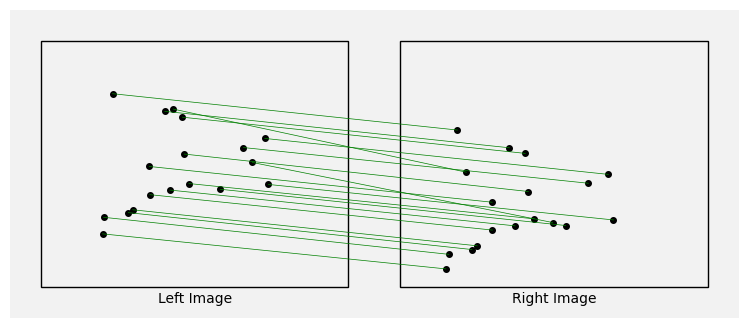

model: [[  1.           0.          75.80547584]
 [  0.           1.         -39.69178237]
 [  0.           0.           1.        ]]
score: 0
ground truth score: 14


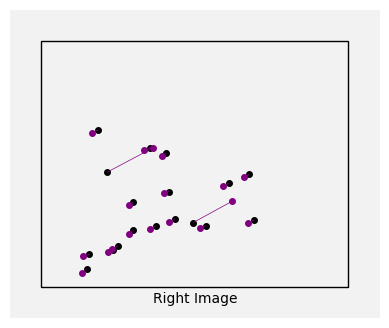

In [15]:
img_w = 600
img_h = 480
num_inlier_matches = 16
num_outlier_matches= 2
sigma_px = 1
T_gt = np.array(
    [[1, 0, 70],
     [0, 1, -30],
     [0, 0, 1]]
)

pts_L, pts_R = make_noisy_match_data(num_inlier_matches, num_outlier_matches, T_gt, img_w, img_h, sigma_px)
visualize_matches(pts_L, pts_R, img_w, img_h)

model = fit_translation_model(pts_L, pts_R)
print('model:', model)
print('score:', score_a_model(pts_L, pts_R, model))
print('ground truth score:', score_a_model(pts_L, pts_R, T_gt))
visualize_model(pts_L, pts_R, model, img_w, img_h)

### RANSAC: RAndom SAmple Consensus

Finding a transformation is a model fitting problem. A simple model fitting problem that we'll use as analogy is **line fitting** (in fact, this is what linear least squares is doing for us, it's just fitting higher-dimensional lines).

**Problem statement**, for now: Given a set of points with some outliers, find the line that fits the non-outliers best.

**Key Idea:** 

> "All good matches are alike; every bad match is bad in its own way."
> 
> -Tolstoy, as misquoted by Alyosha Efros

**Observation**: If I have a candidate model, I can tell how good it is by measuring how many points "agree" on that model.

### Evolution of the Algorithm

**Algorithm, take 1:**
```
for every possible line:
   count how many points are inliers to that line
return the line with the most inliers
```
Runtime: O($\infty$)

**Algorithm, take 2:**
```
for every line that goes through two of the given points:
   count how many points are inliers to that line
return the line with the most inliers
```
Runtime: O(n³)

**Algorithm, take 3: RANSAC**

The key insight: we don't need to try *every* possible line. We just need to try *enough* random samples to have high probability of finding a good one.

```
repeat K times:
    randomly sample s points (minimal set to define the model)
    fit model to these s points
    count how many total points are inliers to this model
return the model with the most inliers
```

For line fitting: s = 2 (two points define a line)

For homography fitting: s = 4 (four point correspondences define a homography)

For translation fitting: s = 1 (one correspondence defines a translation)

### How many iterations K?

Suppose:
- We need $s$ points to fit the model (e.g., s=4 for homography)
- The inlier ratio is $r = \frac{\text{\# inliers}}{\text{\# total points}}$

Then:
- Probability that one randomly sampled point is an inlier: $r$
- Probability that all $s$ sampled points are inliers: $r^s$
- Probability that at least one is an outlier: $1 - r^s$
- Probability that this happens K times in a row (all K iterations fail): $(1 - r^s)^K$
- Probability that at least one iteration succeeds: $p = 1 - (1 - r^s)^K$

Solving for K given desired success probability p:
$$
K = \frac{\log(1-p)}{\log(1-r^s)}
$$

Example: For homography (s=4), with 50% inliers (r=0.5), to get 99% success probability:
$$
K = \frac{\log(0.01)}{\log(1-0.5^4)} = \frac{\log(0.01)}{\log(0.9375)} \approx 72 \text{ iterations}
$$

### Implementing RANSAC

Now let's implement RANSAC and see it work on our synthetic data.

In [19]:
def ransac_translation(pts_L, pts_R, K=100, inlier_threshold=3.0):
    """Fit a translation model using RANSAC.
    
    Args:
        pts_L: 2-by-n left image points
        pts_R: 2-by-n right image points
        K: number of RANSAC iterations
        inlier_threshold: max distance (pixels) for a point to be an inlier
    
    Returns:
        best_model: 3x3 transformation matrix
        best_inliers: boolean array indicating which points are inliers
    """
    n = pts_L.shape[1]
    best_model = None
    best_num_inliers = 0
    best_inliers = None
    
    for iteration in range(K):
        # Sample minimal set (1 correspondence for translation)
        idx = np.random.randint(0, n)
        
        # Fit model to this minimal set
        sample_L = pts_L[:, idx:idx+1]
        sample_R = pts_R[:, idx:idx+1]
        model = fit_translation_model(sample_L, sample_R)
        
        # Count inliers
        pts_R_pred = apply_T(pts_L, model)
        residuals = pts_R - pts_R_pred
        distances = np.sqrt(residuals[0,:]**2 + residuals[1,:]**2)
        inliers = distances < inlier_threshold
        num_inliers = np.sum(inliers)
        
        # Keep track of best model
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_model = model
            best_inliers = inliers
    
    return best_model, best_inliers

RANSAC model:
[[  1.           0.          70.19464782]
 [  0.           1.         -29.07028056]
 [  0.           0.           1.        ]]

Number of inliers found: 14
RANSAC score: 14
Ground truth score: 14


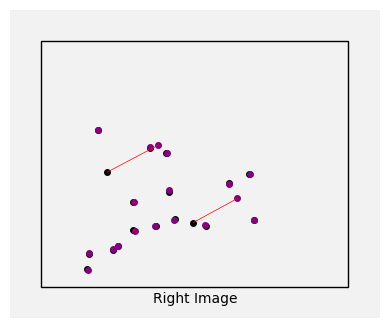

In [20]:
# Test RANSAC on our synthetic data
model_ransac, inliers = ransac_translation(pts_L, pts_R, K=100, inlier_threshold=3.0)

print('RANSAC model:')
print(model_ransac)
print(f'\nNumber of inliers found: {np.sum(inliers)}')
print(f'RANSAC score: {score_a_model(pts_L, pts_R, model_ransac)}')
print(f'Ground truth score: {score_a_model(pts_L, pts_R, T_gt)}')

# Visualize with inliers in green, outliers in red
match_colors = ['g' if inliers[i] else 'r' for i in range(len(inliers))]
visualize_model(pts_L, pts_R, model_ransac, img_w, img_h, match_colors=match_colors)

### Optional: Refining with Least Squares

Once RANSAC identifies the inliers, we can improve the model by refitting using *all* the inliers (not just the minimal set). This is a common post-processing step.

Refined model:
[[  1.           0.          70.41543568]
 [  0.           1.         -28.99155807]
 [  0.           0.           1.        ]]

Refined score: 14


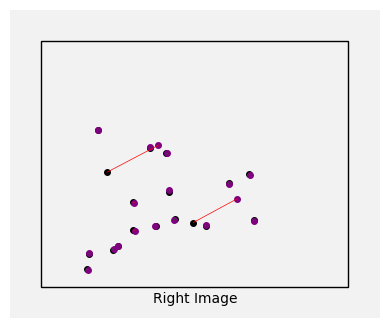

In [21]:
# Refit using all inliers
model_refined = fit_translation_model(pts_L[:, inliers], pts_R[:, inliers])

print('Refined model:')
print(model_refined)
print(f'\nRefined score: {score_a_model(pts_L, pts_R, model_refined)}')

visualize_model(pts_L, pts_R, model_refined, img_w, img_h, match_colors=match_colors)

### Summary

RANSAC is a powerful algorithm for robust model fitting in the presence of outliers.

**Key takeaways:**
1. Least squares fails catastrophically with outliers
2. RANSAC finds the model that maximizes the number of inliers
3. The number of iterations K depends on:
   - Minimal sample size $s$ (larger = need more iterations)
   - Inlier ratio $r$ (lower = need more iterations)
   - Desired success probability $p$ (higher = need more iterations)
4. Optional refinement: refit using all inliers after RANSAC

**In the autostitch project:**
- You'll use RANSAC to fit homographies from feature matches
- The ratio test helps increase the inlier ratio, making RANSAC more effective
- Even with good matches, there will always be some outliers - RANSAC handles them!